# House Prices - Competition

The object of the competition is to predict the house prices as precisely as possible using database that contains 79 explanatory variables of the residental homes in Ames, Iowa.

### Contents of the notebook
1. Importing needed libraries and data
2. Analysing data
3. Choosing features to use
4. Handling missing values
5. Comparing different ML models
6. Doing the final predictions

## Importing needed libraries and data

In [1]:
# Importing needed tools
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Getting the data to train the models
home_filepath = '../input/house-prices-advanced-regression-techniques/train.csv'
full_home_data = pd.read_csv(home_filepath, index_col='Id')

# Getting the data for which we give predictions
test_data_path = '../input/house-prices-advanced-regression-techniques/test.csv'
full_test_data = pd.read_csv(test_data_path, index_col='Id')

## Analysing data

In [2]:
full_home_data.info()
print('************')
full_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

There really is a lot of features. Let's first separate numerical and categorical features.

In [3]:
categorical_cols = [cname for cname in full_home_data.columns if 
                    full_home_data[cname].dtype == "object"]

numerical_cols = [cname for cname in full_home_data.columns if 
                full_home_data[cname].dtype in ['int64', 'float64']]

### Numerical features

Le't check first their correlation with SalePrice. Probably the features that are not correlating with SalePrice could be dropped. 

In [4]:
numeric_corr = full_home_data[numerical_cols].corr()
sale_price_corr_table = numeric_corr['SalePrice'].sort_values(ascending=False).to_frame()

# Adding just some color.
cm = sns.light_palette("darkcyan", as_cmap=True)
sale_price_corr_table.style.background_gradient(cmap=cm).set_precision(3)


,SalePrice
SalePrice,1.000
OverallQual,0.791
GrLivArea,0.709
GarageCars,0.640
GarageArea,0.623
TotalBsmtSF,0.614
1stFlrSF,0.606
FullBath,0.561
TotRmsAbvGrd,0.534
YearBuilt,0.523


Let's see what numerical features have missing values and how much.

In [5]:
#missing numerical data
total = full_home_data[numerical_cols].isnull().sum().sort_values(ascending=False)
percent = ((full_home_data[numerical_cols].isnull().sum() / 
            full_home_data[numerical_cols].isnull().count()) * 100).sort_values(ascending=False)
missing_data_num = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_num = missing_data_num.reset_index()
missing_data_num.columns = ['Name', 'Total', 'Percent']
missing_data_num[(missing_data_num.Total > 0)]

,Name,Total,Percent
0,LotFrontage,259,17.739726
1,GarageYrBlt,81,5.547945
2,MasVnrArea,8,0.547945


Let's look more closely these features that have missing values. 

#### LotFrontage
First one is LotFrontage that presents 'Linear feet of street connected to property'. Since houses in city's do have a frontage (How otherwise you reach a house from the street), these values are missing because they were not recorded. We need to replace them. To see what could be the best strategy for to replace them let's first look if it is highly correlated with some other value.

In [6]:
numeric_corr['LotFrontage'].sort_values(ascending=False).head()

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

Nope, there is not a big correlation to anything. Let's see how this LotFrontage is distributed.

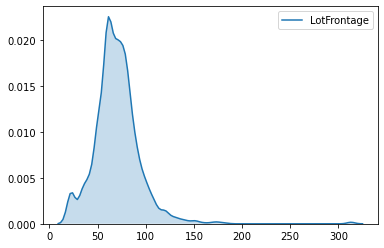

In [8]:
sns.kdeplot(data=full_home_data['LotFrontage'], shade=True);

I will choose to replace this LotFrontage with averages to those entries that are missing this value.

#### GarageYrBlt
This feature tells that what year garage was built. What if there is not a garage. Would this be the reason for this value to be NA?

In [18]:
garage_year_missing = full_home_data[full_home_data['GarageYrBlt'].isna()]
garage_year_missing['GarageCars'].describe()

count    81.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: GarageCars, dtype: float64

Yes, there is not a building year for garage if there is not a garage.

In [ ]:
numeric_corr['LotFrontage'].sort_values(ascending=False).head()


MasVnrArea: Masonry veneer area in square feet

In [ ]:
full_home_data[['BldgType','LotFrontage']].head(30)

In [ ]:
full_home_data[['MasVnrType','MasVnrArea']].isnull().sum()

Eli kahdeksassa talossa ei tietoa ole annettu. Silloin minusta paras oletus, että sitä ei ole.

## Choosing features to use

Right now I only use first the numeric features. Later I will taek also categorical features in play.

Let's choose the ones that correlation with the price is more than 0.25.

In [ ]:
num_features = sale_price_corr_table[(sale_price_corr_table['SalePrice']>0.25) & (sale_price_corr_table['SalePrice']<1)].index.to_list()
full_home_data[num_features].describe()

Let's see how these correlate with each other. If there are terms that correlate with each other a lot, it is not necessary to include them to the features.

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation between features')
sns.heatmap(full_home_data[num_features].corr(), annot=True)

So there is a high correlation between GarareCars and GarageArea, TotalBsmtSF and 1stFlrSF, GrLivArea and TotRmsAbvGrd, YearBlt and GarareYrBlt. Therefore I will remove the features: GarageArea, TotalBsmtSF, TotRmsAbvGrd and GarageYrBlt.

In [ ]:
num_features.remove('GarageArea')
num_features.remove('TotalBsmtSF')
num_features.remove('TotRmsAbvGrd')
num_features.remove('GarageYrBlt')
# this probably could be done with some kind of code, but this was so few of them so I did it by hand.

In [ ]:
full_home_data[num_features].describe()

## Dividing the data to test set and the train set

In [ ]:
# Select target
y = full_home_data.SalePrice

# Select X
X = full_home_data[num_features].copy()
X_test = full_test_data[num_features].copy()

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

## Replacing missing values and making model
First we try very simple method for replacing missing values and see how it goes. Later we figure out more sophisticated methods for replacing missing values.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean') # MAE 18089.78
# numerical_transformer = SimpleImputer(strategy='median') # MAE 18120.04



# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)


# Bundle preprocessing and modeling code in a pipeline
regressor = Pipeline(steps=[('preprocessor', numerical_transformer),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
regressor.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = regressor.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

### Other possible model

In [ ]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor(n_estimators= 1000, learning_rate=0.05, random_state=0)

# Fit the model
my_model_1.fit(X_train, y_train)

preds2 = my_model_1.predict(X_valid)
print('MAE:', mean_absolute_error(y_valid, preds2))

## Making final predictions of test data

In [ ]:
final_regressor = XGBRegressor(n_estimators= 1000, learning_rate=0.05, random_state=0)
final_regressor.fit(X,y)
preds_test = final_regressor.predict(X_test)

In [ ]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

Altought it here seems that the XGBRegressor gives a better model, the test results the RandomForestRegressor predicted better when I submitted them.